# Import important stuff


In [1]:
# Who does not need math in his life?
import math

# Phases will be returned as floats and we want factions!
from fractions import Fraction

# The infamous numpy module, with C-compiled code for quick maths
import numpy as np

# Braket SDK v1.61.0
# Circuits !
from braket.circuits import Circuit, circuit
# Qubits !
from braket.circuits.qubit_set import QubitSetInput, QubitSet
from braket.circuits.qubit import Qubit

# Devices !
from braket.devices import Device, LocalSimulator   # Local simulator
local_simulator = LocalSimulator()
from braket.aws import AwsDevice    # AWS simulators/QPU

# Devices return results (hopefully !) containing a Counter
from collections import Counter

# Functions are commented with a clear input/output typing to help you
from typing import Any, Dict, List, Optional
# We will choose `a` as random to run Shor's algorithm (1 < a < N)
from random import randint, sample
# If we need to wait for the Device to finish a simulation, better sleep a little
from time import sleep
# For log displays
from datetime import datetime

# Little function that efficiently compute the bit-size of an integer
def bit_size_of(integer_N):
    s = 0
    while integer_N > 0:
        integer_N = integer_N // 2
        s += 1
    return s

# Througout the implementation, we compute 2*math.pi/(2**k) a LOT (like, a LOT LOT)
# We can easily go north of millions of computing the same value over and over even with 
# relatively low value of N to factor
# So we cache the value
cache_pi_over_2_pow_k = {}
def pi_over_2_pow_k(k):
    r = cache_pi_over_2_pow_k.get(k)
    if r is None:
        r = 2*math.pi/(2**k)
        cache_pi_over_2_pow_k[k] = r
    return r

# Qiskit produces nice images of quantum circuits
# We want to do them from Braket circuits
from braket.circuits.serialization import IRType
import qiskit.qasm3
def braket_to_qiskit_circuit(braket_circuit, without_measurements = False):
    # Produce QASM3 string
    qasm_str = braket_circuit.to_ir(IRType.OPENQASM).source
    # Split lines
    qasm_str_lines = qasm_str.split('\n')
    # Include the stdgates.inc
    qasm_str_lines.insert(1, 'include "stdgates.inc";')
    # Index of the first measurement
    index_of_first_measure = qasm_str_lines.index("b[0] = measure q[0];")
    
    if without_measurements:
        # Remove instructions relative to classical bits and measures
        qasm_str_lines = qasm_str_lines[:index_of_first_measure]
        qasm_str_lines.remove(f"bit[{braket_circuit.qubit_count}] b;")
    else:
        # Include a barrier to separate measurements
        qasm_str_lines.insert(index_of_first_measure, f'barrier;')
    
    # Regroup lines
    qasm_str = '\n'.join(qasm_str_lines)
    # Replace Braket gate names with std ones
    qasm_str = qasm_str.replace("cphaseshift", "cphase").replace("phaseshift", "phase").replace("cnot", "cx")
    # Create the Qiskit circuit
    return qiskit.qasm3.loads(qasm_str)


# Create the QFT circuit
The Quantum Fourier Transform is the well-known circuit allowing to change a state vector from the computational basis to the Fourier basis.
In Shor's algorithm, we use the modular exponentiation controlled by a register `reg_x`. There is a "phase kickback effect" that will inprint the phase of the modular exponentiation into `reg_x` "written" in the Fourrier basis. We use QFT-dagger to transform that in the computational basis, so that we can measure it.

In [2]:
# Compared to implementations found on the Internet, this one is different because my convention is to
# encode number in little endian
# So for example, if a registry contains 4 qubits q0, q1, q2 and q3:
# 1 => q0=1, q1=0, q2=0, q3=0
# 2 => q0=0, q1=1, q2=0, q3=0
# 4 => q0=0, q1=0, q2=1, q3=0
# 8 => q0=0, q1=0, q2=0, q3=1
# 7 => q0=1, q1=1, q2=1, q3=0
# Most implementation on the Internet use a BigEndian encoding (I'm not sure why) and it changes things for QFT
@circuit.subroutine(register=True)
def qft(
    qubits: QubitSetInput,
    reverse: Optional[bool] = False,
    do_swaps: Optional[bool] = True,
) -> Circuit:
    """
    Construct a circuit object corresponding to the inverse Quantum Fourier Transform (QFT)
    algorithm, applied to the argument qubits.  Does not use recursion to generate the circuit.
    
    Args:
        qubits (QubitSetInput): Qubits on which to apply the inverse Quantum Fourier Transform
        reverse (Optional[bool]): Create a reversed version of this circuit
    Returns:
        Circuit: Circuit object that implements the inverse Quantum Fourier Transform algorithm
    """
    qftcirc = Circuit()
    
    # get number of qubits
    num_qubits = len(qubits)
    
    for k in reversed(range(num_qubits)):
        # First add a Hadamard gate
        qftcirc.h(qubits[k])
    
        # Then apply the controlled rotations, with weights (angles) defined by the distance to the control qubit.
        # Start on the qubit after qubit k, and iterate until the end.  When num_qubits==1, this loop does not run.
        for j in reversed(range(k)):
            # angle = 2*math.pi/(2**(1+k-j))
            angle = pi_over_2_pow_k(1+k-j)
            if reverse:
                angle = -angle
            qftcirc.cphaseshift(qubits[j], qubits[k], angle)
            
    # Then add SWAP gates to reverse the order of the qubits:
    if do_swaps:
        for i in range(math.floor(num_qubits/2)):
            qftcirc.swap(qubits[i], qubits[-i-1])

    # If the reversed Gate is asked, we simply reverse the instructions order
    if reverse:
        qftcirc = Circuit(reversed(qftcirc.instructions))

    return qftcirc

We can display this circuit for an arbitrary number of qubits to see what it looks like:

'qft with 3 qubits:'

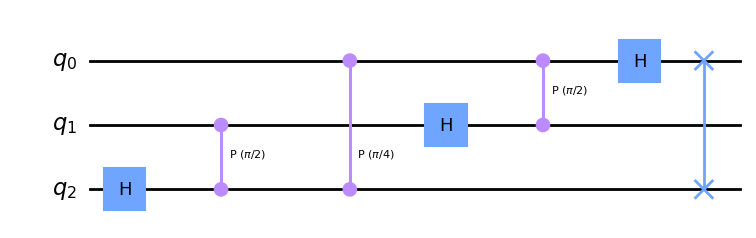

'qft_dagger with 3 qubits:'

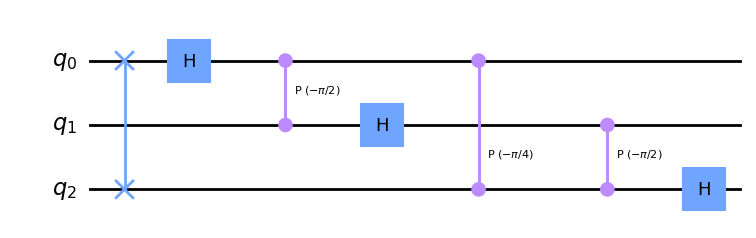

In [4]:
EXAMPLE_QUBIT_COUNT=3
display(f"qft with {EXAMPLE_QUBIT_COUNT} qubits:")
display(braket_to_qiskit_circuit(qft([*range(EXAMPLE_QUBIT_COUNT)]), True).draw('mpl'))
display(f"qft_dagger with {EXAMPLE_QUBIT_COUNT} qubits:")
display(braket_to_qiskit_circuit(qft([*range(EXAMPLE_QUBIT_COUNT)], reverse=True), True).draw('mpl'))

# Create the generic modular exponentiation
The following is based on https://arxiv.org/pdf/quant-ph/0205095.pdf

This is a somewhat advanced implementation of the Shor's algorithm. For a more straightforward approach that may better suits you if you are discovering the subject, please first play with the notebook `shors-1-7n+2.ipynb`.

Our goal here is to tweak and optimize the number of qubits needed for the algorithm. It results in a much more efficient implementation, but at the cost of a less straightforward code. In particular the addition is done in the Fourier space, which is difficult to intuit for humans.

But we get a version of Shor's algorithm that need only 4n+3 qubits.

In the original paper, the author gets an implementation with 2n+3 qubits, but in order to achieve this, he supposes an ability to create controlled-gates without restriction (which we cannot do with the Braket SDK, unless we are willing to pay a very high performance cost by creating custom Unitary matrixes) as well as a capacity to perform measurements while the circuit is running and then change gates dynamically, which allows to replace the 2n qubit of the register x with just one qubit. That last one is theoricaly possible, but it is not possible with Amazon Braket SDK nor any other SDK or current quantum computer as far as I know so...

What we get is therefore the optimal implementation I can think of with AWS Braket: 4n+3 qubit where n is the minimal number of bits required to write N, the number to factor.

For example:
- N=15 => n=4 => 19 qubits
- N=21 => n=5 => 23 qubits
- N=77 => n=7 => 31 qubits (which will take roughly 90min to simulate on a super-computer and won't even start on your laptop so be carreful)

## Adder circuit
This is a adder operating in the Fourrier space.

So it maps `|PSI(b)>` to `|PSI(b+a)>` with `a` a classically known integer and `b` an integer contained in a quantum registry.


In [5]:
@circuit.subroutine(register=True)
def q_ctrl_adder(
    a: int,
    q_ctrl: Qubit,
    reg_b: QubitSetInput,
    reverse: Optional[bool] = False,
) -> Circuit:
    """
    Construct a circuit object, that will become our generic Gate
    Args:
        a (int): The number a
        q_ctrl (Qubit): the ctrl_qubit, can be set to None to obtaing a un-controlled version of the circuit
        reg_b (QubitSetInput): Register of the number b, expected to contains PHI(b) at the begining
            and will contain PHI(a + b) at the end of the circuit
        reverse (Optional[bool]): Create a reversed version of this circuit
    Returns:
        Circuit: Resulting circuit that can be used as a Gate in a more complex circuit
    """
    
    # Instantiate circuit object
    c = Circuit()

    # For each qubit of reg_b, from lower significance to higher
    for b_i in range(len(reg_b)):
        # Start with a 0 angle
        angle = 0
        # For each bit of the number a to add up to the same bit in b
        # from lower significance to higher, 
        for a_i in range(b_i+1):
            # If the ith bit in a is a 1
            if 2**a_i & a:
                # Add an angle to the future phase rotation
                # k is 1 plus the distance between the bit in a and the bit in b
                k = 1 + b_i - a_i
                # The angle to add is 2*pi/2^k
                # angle += 2*math.pi/(2**k)
                angle += pi_over_2_pow_k(k)
        # In the end, if the angle is non-zero
        if angle > 0:
            # If we are create the reverse circuit, inverse the angle
            if reverse:
                angle = -angle
            # If we are creating a not-controlled version of the circuit, apply the phase rotation
            if q_ctrl is None:
                c.phaseshift(reg_b[b_i], angle)
            # If we are creating the controlled (regular) version of the circuit,
            # apply a controlled phase rotation
            else:
                c.cphaseshift(q_ctrl, reg_b[b_i], angle)
    
    return c


In [6]:
# Bit-size of integers a and b
n = 3
# Max value of integers a and b
N = 2**n - 1

# Register for integer b, of size n+1 because it will contains a+b in the end, which can be 1 bit longer than a and b
reg_b = [*range(0, n+1)]
# q_ctrl the control qubit that our adder can use
q_ctrl = len(reg_b)

# For all possible n-bit integers a, verify that our q_ctrl_adder works as expected
for a in range(N+1):
    # For all possible n-bit integers b
    for b in range(N+1):
        # New circuit
        c_q_adder = Circuit()
        # Apply a not-not (which does nothing) to reg_b
        # This is because braket only knows a qubit exist in the circuit if it sees it at least once
        # so we have to do that for our test, else in some case it will complain that we gave it non-contiguous qubits
        c_q_adder.x(reg_b)
        c_q_adder.x(reg_b)

        # Set the q_ctrl qubit to one
        c_q_adder.x(q_ctrl)

        # Initialize reg_b according to the value of b
        # For each bit
        for i in range(n):
            # If the i-th bit in the integer b is 1
            if 2**i & b:
                # Flip the corresponding qubit in reg_b with a not-gate (thus changing it from 0 (the default) to 1)
                c_q_adder.x(reg_b[i])

        # Create the adder using our register reg_b
        # Transform reg_b to PHI(b), that is put b in the Fourier space
        c_q_adder.qft(reg_b, do_swaps=False)
        # Perform the operation
        c_q_adder.q_ctrl_adder(a, q_ctrl, reg_b)
        # Transform b back in the regular computational basis
        c_q_adder.qft(reg_b, reverse=True, do_swaps=False)
        # Now simulate the circuit 1000 times and retrieve the measures
        measurement = local_simulator.run(c_q_adder, shots=1000).result().measurement_counts
        # There should only be one result because this circuit should be completly deterministic
        assert len(measurement) == 1, f"Expected only one result, got {len(measurement)}: {measurement}"
        for measure in measurement.keys():
            # Extract the bits for reg_b only from the resulting measurement, reverse them and convert them to the corresponding int
            result = int(''.join(reversed(measure[:len(reg_b)])), 2)
            expected = a + b
            # Verify that we obtain the correct result
            assert expected == result, f"({a} + {b}) = {expected} not {result}"
display("q_ctrl_adder behave as expected")


# For all possible n-bit integers a, verify that our REVERSED-q_ctrl_adder works as expected
for a in range(N+1):
    # For all possible n-bit integers b
    for b in range(N+1):
        # New circuit
        c_q_adder = Circuit()
        # Apply a not-not (which does nothing) to reg_b
        # This is because braket only knows a qubit exist in the circuit if it sees it at least once
        # so we have to do that for our test, else in some case it will complain that we gave it non-contiguous qubits
        c_q_adder.x(reg_b)
        c_q_adder.x(reg_b)

        # Set the q_ctrl qubit to one
        c_q_adder.x(q_ctrl)

        # Initialize reg_b according to the value of b
        # For each bit
        for i in range(n):
            # If the i-th bit in the integer b is 1
            if 2**i & b:
                # Flip the corresponding qubit in reg_b with a not-gate (thus changing it from 0 (the default) to 1)
                c_q_adder.x(reg_b[i])

        # Create the adder using our register reg_b
        # Transform reg_b to PHI(b), that is put b in the Fourier space
        c_q_adder.qft(reg_b, do_swaps=False)
        # Perform the inverse operation
        c_q_adder.q_ctrl_adder(a, q_ctrl, reg_b, reverse=True)
        # Transform b back in the regular computational basis
        c_q_adder.qft(reg_b, reverse=True, do_swaps=False)
        # Now simulate the circuit 1000 times and retrieve the measures
        measurement = local_simulator.run(c_q_adder, shots=1000).result().measurement_counts
        # There should only be one result because this circuit should be completly deterministic
        assert len(measurement) == 1, f"Expected only one result, got {len(measurement)}: {measurement}"
        for measure in measurement.keys():
            # Extract the bits for reg_b only from the resulting measurement, reverse them and convert them to the corresponding int
            result = int(''.join(reversed(measure[:len(reg_b)])), 2)
            # We expect to obtain the subtraction b-a modulo 2**(n+1) (the size of reg_b)
            expected = (b - a) % 2**(n+1)
            # Verify that we obtain the correct result
            assert expected == result, f"({b} - {a}) = {expected} not {result}"
display("q_ctrl_adder-dagger behave as expected")


# Test the reversibility
# For all possible n-bit integers a, verify that our q_ctrl_adder works as expected
for a in range(N+1):
    # For all possible n-bit integers b
    for b in range(N+1):
        # New circuit
        c_q_adder = Circuit()
        # Apply a not-not (which does nothing) to reg_b
        # This is because braket only knows a qubit exist in the circuit if it sees it at least once
        # so we have to do that for our test, else in some case it will complain that we gave it non-contiguous qubits
        c_q_adder.x(reg_b)
        c_q_adder.x(reg_b)

        # Set the q_ctrl qubit to one
        c_q_adder.x(q_ctrl)

        # Initialize reg_b according to the value of b
        # For each bit
        for i in range(n):
            # If the i-th bit in the integer b is 1
            if 2**i & b:
                # Flip the corresponding qubit in reg_b with a not-gate (thus changing it from 0 (the default) to 1)
                c_q_adder.x(reg_b[i])

        # Create the adder using our register reg_b
        # Transform reg_b to PHI(b), that is put b in the Fourier space
        c_q_adder.qft(reg_b, do_swaps=False)
        # Perform the operation
        c_q_adder.q_ctrl_adder(a, q_ctrl, reg_b)
        # Then the inverse
        c_q_adder.q_ctrl_adder(a, q_ctrl, reg_b, reverse=True)
        # Transform b back in the regular computational basis
        c_q_adder.qft(reg_b, reverse=True, do_swaps=False)
        # Now simulate the circuit 1000 times and retrieve the measures
        measurement = local_simulator.run(c_q_adder, shots=1000).result().measurement_counts
        # There should only be one result because this circuit should be completly deterministic
        assert len(measurement) == 1, f"Expected only one result, got {len(measurement)}: {measurement}"
        for measure in measurement.keys():
            # Extract the bits for reg_b only from the resulting measurement, reverse them and convert them to the corresponding int
            result = int(''.join(reversed(measure[:len(reg_b)])), 2)
            expected = b
            # Verify that we obtain the correct result
            assert expected == result, f"Expect {expected} not {result}"
display("q_ctrl_adder is inversible as expected")


# Test the control qubit
# For all possible n-bit integers a, verify that our q_ctrl_adder does nothing if q_ctrl is 0
for a in range(N+1):
    # For all possible n-bit integers b
    for b in range(N+1):
        # New circuit
        c_q_adder = Circuit()
        # Apply a not-not (which does nothing) to reg_b
        # This is because braket only knows a qubit exist in the circuit if it sees it at least once
        # so we have to do that for our test, else in some case it will complain that we gave it non-contiguous qubits
        c_q_adder.x(reg_b)
        c_q_adder.x(reg_b)

        # Initialize reg_b according to the value of b
        # For each bit
        for i in range(n):
            # If the i-th bit in the integer b is 1
            if 2**i & b:
                # Flip the corresponding qubit in reg_b with a not-gate (thus changing it from 0 (the default) to 1)
                c_q_adder.x(reg_b[i])

        # Create the adder using our register reg_b
        # Transform reg_b to PHI(b), that is put b in the Fourier space
        c_q_adder.qft(reg_b, do_swaps=False)
        # Perform the operation
        c_q_adder.q_ctrl_adder(a, q_ctrl, reg_b)
        # Transform b back in the regular computational basis
        c_q_adder.qft(reg_b, reverse=True, do_swaps=False)
        # Now simulate the circuit 1000 times and retrieve the measures
        measurement = local_simulator.run(c_q_adder, shots=1000).result().measurement_counts
        # There should only be one result because this circuit should be completly deterministic
        assert len(measurement) == 1, f"Expected only one result, got {len(measurement)}: {measurement}"
        for measure in measurement.keys():
            # Extract the bits for reg_b only from the resulting measurement, reverse them and convert them to the corresponding int
            result = int(''.join(reversed(measure[:len(reg_b)])), 2)
            expected = b
            # Verify that we obtain the correct result
            assert expected == result, f"Expect {expected} not {result}"
display("q_ctrl_adder does nothing when q_ctrl=0 as expected")

'q_ctrl_adder behave as expected'

'q_ctrl_adder-dagger behave as expected'

'q_ctrl_adder is inversible as expected'

'q_ctrl_adder does nothing when q_ctrl=0 as expected'

'q_ctrl_adder(a=63):'

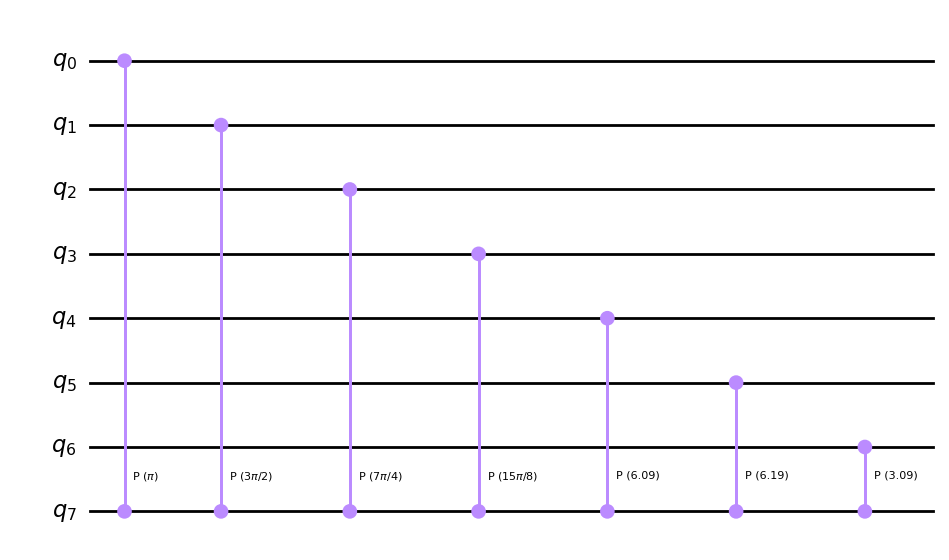

In [7]:
# Bit-size of integers a and b
EXAMPLE_QUBIT_COUNT=6
a=2**EXAMPLE_QUBIT_COUNT-1
# Register for integer b, of size n+1 because it will contains a+b in the end, which can be 1 bit longer than a and b
reg_b = [*range(0, (EXAMPLE_QUBIT_COUNT + 1))]
# Display the resulting circuit
display(f"q_ctrl_adder(a={a}):")
display(braket_to_qiskit_circuit(q_ctrl_adder(a, len(reg_b), reg_b), True).draw('mpl'))

## Adder modulo N circuit
At the end, `reg_b = (a + reg_b) % N`

In [8]:
@circuit.subroutine(register=True)
def q_cctrl_adder_modN(
    N: int,
    a: int,
    q_ctrl1: Qubit,
    q_ctrl2: Qubit,
    reg_b: QubitSetInput,
    anciliaries: QubitSetInput,
    reverse = False
) -> Circuit:
    """
    Construct a circuit object, that will become our generic Gate for the doubly-controlled modular addition.
    Args:
        N (int): The number N, used to hard-code some part of the circuit
        a (int): The number a, used to hard-code some part of the circuit
        reg_b (QubitSetInput): Register of the number b, expected to contains PHI(b) at the begining
            and will contain PHI((b + a) % N) at the end of the circuit
        anciliaries (QubitSetInput): Register storing intermediate results, expected to be |0>
            at the begining of the circuit and will be left unchanged at the end
        reverse (bool): Create a reversed version of this circuit
    Returns:
        Circuit: Resulting circuit that can be used as a Gate in a more complex circuit
    """
    # The number of bit required to represent N
    n = bit_size_of(N)
    # B should always be n+1
    assert len(reg_b) == n + 1
    # We need 2 anciliaries for this circuit
    assert len(anciliaries) == 2
    # a should be strictly less than N
    assert a < N
    
    c = Circuit()
    
    if not reverse:
        # Use anciliaries[0] to store ctrl1^ctrl2 using a Tofoli gate
        c.ccnot(q_ctrl1, q_ctrl2, anciliaries[0])
        # Add a and reg_b (if ctrl1^ctrl2=1)
        c.q_ctrl_adder(a, anciliaries[0], reg_b)
        # Substract N, no matter what
        c.q_ctrl_adder(N, None, reg_b, reverse=True)
        
        # At this point, reg_b contains a + b - N if ctrl1^ctrl2=1 ; or b - N if ctrl1^ctrl2=0
        # We want to verify if it is negative or not.
        # anciliaries[1] will be :
        #    1 if reg_b < 0
        #    0 if reg_b >= 0
        # because the most significant bit of reg_b can only be 1 if reg_b contains a negative number
        # as we are always carreful to have b < N at the start of the circuit
        # Transform reg_b to the computational basis
        c.qft(reg_b, reverse=True, do_swaps=False)
        # Verify its most-significant qubit
        c.cnot(reg_b[-1], anciliaries[1])
        # Transform reg_b back to the Fourier basis
        c.qft(reg_b, do_swaps=False)
        # Add back N, controlled by anciliaries[1]
        c.q_ctrl_adder(N, anciliaries[1], reg_b)
        
        # Now reset anciliaries[1] to its original value |0>
        # Here is how it works. There is exactly 2 possibilities. At this point, either anciliaries[1] was set to 1 or it was left to 0.
        #
        # Observe that anciliaries[1] was set to 0 if and only if a + b - N >= 0 ; so in that case reg_b = a + b - N
        # If we substract a, reg_b = b - N which is bound to be negative: as b is always a value modulo N, it must be strictly less than N, therefore b - N < 0
        # Which means that after substracting a, the most significant qubit of reg_b will be 1, so using its inverse for a CNOT operation on anciliaries[1]
        # will leave it to 0.
        #
        # On the other hand, anciliaries[1] is 1 if and only if a + b - N < 0 ; so in that case reg_b = a + b (because we added back N previously)
        # If we substract a, reg_b = b. As b is a number that can be written we n-bits and size(reg_b) = n + 1 ; the most significant qubit of reg_b must be 0.
        # So using its inverse for a CNOT operation on anciliaries[1] will set it back to 0.
        #
        # Un-add a with a reverse adder
        c.q_ctrl_adder(a, anciliaries[0], reg_b, reverse=True)
        # CNOT operation on anciliaries[1] using the inverse of the most significant qubit of reg_b as the control
        # Transform reg_b to the computational basis
        c.qft(reg_b, reverse=True, do_swaps=False)
        # negate the most significant qubit of reg_b
        c.x(reg_b[-1])
        # Use it for CNOT on anciliaries[1]
        c.cnot(reg_b[-1], anciliaries[1])
        # re-negate the most significant qubit of reg_b to set it back as it was
        c.x(reg_b[-1])
        # Transform reg_b back to the Fourier basis
        c.qft(reg_b, do_swaps=False)
        # Re-add a
        c.q_ctrl_adder(a, anciliaries[0], reg_b)
        # Return anciliaries[0] to its orig value
        c.ccnot(q_ctrl1, q_ctrl2, anciliaries[0])
    
    # If we want the reversed circuit, we perform the inverse operations (operation-dagger) in the inverse order
    else:
        c.ccnot(q_ctrl1, q_ctrl2, anciliaries[0])
        c.q_ctrl_adder(a, anciliaries[0], reg_b, reverse=True)
        c.qft(reg_b, do_swaps=False, reverse=True)
        c.x(reg_b[-1])
        c.cnot(reg_b[-1], anciliaries[1])
        c.x(reg_b[-1])
        c.qft(reg_b, do_swaps=False)
        c.q_ctrl_adder(a, anciliaries[0], reg_b)
        c.q_ctrl_adder(N, anciliaries[1], reg_b, reverse=True)
        c.qft(reg_b, reverse=True, do_swaps=False)
        c.cnot(reg_b[-1], anciliaries[1])
        c.qft(reg_b, do_swaps=False)
        c.q_ctrl_adder(N, None, reg_b)
        c.q_ctrl_adder(a, anciliaries[0], reg_b, reverse=True)
        c.ccnot(q_ctrl1, q_ctrl2, anciliaries[0])
    return c


In [9]:
# Controls that the circuit is actually performing correctly for all possible value <= 7 MOD 7

# Fix the N
N = 7
# Find the minimum number of bits required to represent N
n = bit_size_of(N)
# Register for integer b, of size n+1 because it will contains a+b in the end, which can be 1 bit longer than a and b
reg_b = [*range(0, n + 1)]
# anciliaries
anciliaries = [*range(len(reg_b) + 0, len(reg_b) + 2)]
# Two ctrl-qubits
q_ctrl1 = len(reg_b) + len(anciliaries)
q_ctrl2 = len(reg_b) + len(anciliaries) + 1


# For all possible n-bit integers a, verify that our q_cctrl_adder_modN works as expected
for a in range(N):
    # For all possible n-bit integers b
    for b in range(N):
        # New circuit
        c_q_adder_modN = Circuit()
        # Apply a not-not (which does nothing) to all qubits
        # This is because braket only knows a qubit exist in the circuit if it sees it at least once
        # so we have to do that for our test, else in some case it will complain that we gave it non-contiguous qubits
        c_q_adder_modN.x(reg_b + anciliaries + [q_ctrl1, q_ctrl2])
        # Note that we leave q_ctrl1, q_ctrl2 with the value 1
        c_q_adder_modN.x(reg_b + anciliaries)

        # Initialize reg_b according to the value of b
        # For each bit
        for i in range(n):
            # If the i-th bit in the integer b is 1
            if 2**i & b:
                # Flip the corresponding qubit in reg_b with a not-gate (thus changing it from 0 (the default) to 1)
                c_q_adder_modN.x(reg_b[i])

        # Create the adder using our register reg_b
        # Transform reg_b to PHI(b), that is put b in the Fourier space
        c_q_adder_modN.qft(reg_b, do_swaps=False)
        # Perform the operation
        c_q_adder_modN.q_cctrl_adder_modN(N, a, q_ctrl1, q_ctrl2, reg_b, anciliaries)
        # Transform b back in the regular computational basis
        c_q_adder_modN.qft(reg_b, reverse=True, do_swaps=False)
        # Now simulate the circuit 1000 times and retrieve the measures
        measurement = local_simulator.run(c_q_adder_modN, shots=1000).result().measurement_counts
        # There should only be one result because this circuit should be completly deterministic
        assert len(measurement) == 1, f"Expected only one result, got {len(measurement)}: {measurement}"
        for measure in measurement.keys():
            # Extract the bits for reg_b only from the resulting measurement, reverse them and convert them to the corresponding int
            result = int(''.join(reversed(measure[:len(reg_b)])), 2)
            expected = (a + b) % N
            # Verify that we obtain the correct result
            assert expected == result, f"({a} + {b}) % {N} = {expected} not {result}"
display("q_cctrl_adder_modN behave as expected")

# For all possible n-bit integers a, verify that our q_cctrl_adder_modN works as expected
for a in range(N):
    # For all possible n-bit integers b
    for b in range(N):
        # New circuit
        c_q_adder_modN = Circuit()
        # Apply a not-not (which does nothing) to all qubits
        # This is because braket only knows a qubit exist in the circuit if it sees it at least once
        # so we have to do that for our test, else in some case it will complain that we gave it non-contiguous qubits
        c_q_adder_modN.x(reg_b + anciliaries + [q_ctrl1, q_ctrl2])
        # Note that we leave q_ctrl1, q_ctrl2 with the value 1
        c_q_adder_modN.x(reg_b + anciliaries)

        # Compute (a + b) % N
        b_after = (a + b) % N
        # Initialize reg_b according to the value of b
        # For each bit
        for i in range(n):
            # If the i-th bit in the integer b is 1
            if 2**i & b_after:
                # Flip the corresponding qubit in reg_b with a not-gate (thus changing it from 0 (the default) to 1)
                c_q_adder_modN.x(reg_b[i])

        # Create the adder using our register reg_b
        # Transform reg_b to PHI(b), that is put b in the Fourier space
        c_q_adder_modN.qft(reg_b, do_swaps=False)
        # Perform the reverse operation
        c_q_adder_modN.q_cctrl_adder_modN(N, a, q_ctrl1, q_ctrl2, reg_b, anciliaries, reverse=True)
        # Transform b back in the regular computational basis
        c_q_adder_modN.qft(reg_b, reverse=True, do_swaps=False)
        # Now simulate the circuit 1000 times and retrieve the measures
        measurement = local_simulator.run(c_q_adder_modN, shots=1000).result().measurement_counts
        # There should only be one result because this circuit should be completly deterministic
        assert len(measurement) == 1, f"Expected only one result, got {len(measurement)}: {measurement}"
        for measure in measurement.keys():
            # Extract the bits for reg_b only from the resulting measurement, reverse them and convert them to the corresponding int
            result = int(''.join(reversed(measure[:len(reg_b)])), 2)
            expected = b
            # Verify that we obtain the correct result
            assert expected == result, f"Expected {expected} not {result}"
display("q_cctrl_adder_modN-dagger behave as expected")

# For all possible n-bit integers a, verify that our q_cctrl_adder_modN is inversible
for a in range(N):
    # For all possible n-bit integers b
    for b in range(N):
        # New circuit
        c_q_adder_modN = Circuit()
        # Apply a not-not (which does nothing) to all qubits
        # This is because braket only knows a qubit exist in the circuit if it sees it at least once
        # so we have to do that for our test, else in some case it will complain that we gave it non-contiguous qubits
        c_q_adder_modN.x(reg_b + anciliaries + [q_ctrl1, q_ctrl2])
        # Note that we leave q_ctrl1, q_ctrl2 with the value 1
        c_q_adder_modN.x(reg_b + anciliaries)

        # Initialize reg_b according to the value of b
        # For each bit
        for i in range(n):
            # If the i-th bit in the integer b is 1
            if 2**i & b:
                # Flip the corresponding qubit in reg_b with a not-gate (thus changing it from 0 (the default) to 1)
                c_q_adder_modN.x(reg_b[i])

        # Create the adder using our register reg_b
        # Transform reg_b to PHI(b), that is put b in the Fourier space
        c_q_adder_modN.qft(reg_b, do_swaps=False)
        # Perform the operation
        c_q_adder_modN.q_cctrl_adder_modN(N, a, q_ctrl1, q_ctrl2, reg_b, anciliaries)
        # Then immediatly the inverse
        c_q_adder_modN.q_cctrl_adder_modN(N, a, q_ctrl1, q_ctrl2, reg_b, anciliaries, reverse=True)
        # Transform b back in the regular computational basis
        c_q_adder_modN.qft(reg_b, reverse=True, do_swaps=False)
        # Now simulate the circuit 1000 times and retrieve the measures
        measurement = local_simulator.run(c_q_adder_modN, shots=1000).result().measurement_counts
        # There should only be one result because this circuit should be completly deterministic
        assert len(measurement) == 1, f"Expected only one result, got {len(measurement)}: {measurement}"
        for measure in measurement.keys():
            # Extract the bits for reg_b only from the resulting measurement, reverse them and convert them to the corresponding int
            result = int(''.join(reversed(measure[:len(reg_b)])), 2)
            expected = b
            # Verify that we obtain the correct result
            assert expected == result, f"Expected {expected} not {result}"
display("q_cctrl_adder_modN is inversible as expected")

# For all possible n-bit integers a, verify that our q_cctrl_adder_modN does nothing if a ctrl qubit is 0 as expected
for a in range(N):
    # For all possible n-bit integers b
    for b in range(N):
        # New circuit
        c_q_adder_modN = Circuit()
        # Apply a not-not (which does nothing) to all qubits
        # This is because braket only knows a qubit exist in the circuit if it sees it at least once
        # so we have to do that for our test, else in some case it will complain that we gave it non-contiguous qubits
        c_q_adder_modN.x(reg_b + anciliaries + [q_ctrl1, q_ctrl2])
        # Note that we set back q_ctrl1 to 0
        c_q_adder_modN.x(reg_b + anciliaries + [q_ctrl1])

        # Initialize reg_b according to the value of b
        # For each bit
        for i in range(n):
            # If the i-th bit in the integer b is 1
            if 2**i & b:
                # Flip the corresponding qubit in reg_b with a not-gate (thus changing it from 0 (the default) to 1)
                c_q_adder_modN.x(reg_b[i])

        # Create the adder using our register reg_b
        # Transform reg_b to PHI(b), that is put b in the Fourier space
        c_q_adder_modN.qft(reg_b, do_swaps=False)
        # Perform the operation
        c_q_adder_modN.q_cctrl_adder_modN(N, a, q_ctrl1, q_ctrl2, reg_b, anciliaries)
        # Transform b back in the regular computational basis
        c_q_adder_modN.qft(reg_b, reverse=True, do_swaps=False)
        # Now simulate the circuit 1000 times and retrieve the measures
        measurement = local_simulator.run(c_q_adder_modN, shots=1000).result().measurement_counts
        # There should only be one result because this circuit should be completly deterministic
        assert len(measurement) == 1, f"Expected only one result, got {len(measurement)}: {measurement}"
        for measure in measurement.keys():
            # Extract the bits for reg_b only from the resulting measurement, reverse them and convert them to the corresponding int
            result = int(''.join(reversed(measure[:len(reg_b)])), 2)
            expected = b
            # Verify that we obtain the correct result
            assert expected == result, f"Expected {expected} not {result}"
display("q_cctrl_adder_modN is controllable as expected")

# For all possible n-bit integers a, verify that our q_cctrl_adder_modN works as expected
for a in range(N):
    # For all possible n-bit integers b
    for b in range(N):
        # New circuit
        c_q_adder_modN = Circuit()
        # Apply a not-not (which does nothing) to all qubits
        # This is because braket only knows a qubit exist in the circuit if it sees it at least once
        # so we have to do that for our test, else in some case it will complain that we gave it non-contiguous qubits
        c_q_adder_modN.x(reg_b + anciliaries + [q_ctrl1, q_ctrl2])
        # Note that we set back q_ctrl1 to 0
        c_q_adder_modN.x(reg_b + anciliaries + [q_ctrl1])

        # Compute (a + b) % N
        b_after = (a + b) % N
        # Initialize reg_b according to the value of b
        # For each bit
        for i in range(n):
            # If the i-th bit in the integer b is 1
            if 2**i & b_after:
                # Flip the corresponding qubit in reg_b with a not-gate (thus changing it from 0 (the default) to 1)
                c_q_adder_modN.x(reg_b[i])

        # Create the adder using our register reg_b
        # Transform reg_b to PHI(b), that is put b in the Fourier space
        c_q_adder_modN.qft(reg_b, do_swaps=False)
        # Perform the reverse operation
        c_q_adder_modN.q_cctrl_adder_modN(N, a, q_ctrl1, q_ctrl2, reg_b, anciliaries, reverse=True)
        # Transform b back in the regular computational basis
        c_q_adder_modN.qft(reg_b, reverse=True, do_swaps=False)
        # Now simulate the circuit 1000 times and retrieve the measures
        measurement = local_simulator.run(c_q_adder_modN, shots=1000).result().measurement_counts
        # There should only be one result because this circuit should be completly deterministic
        assert len(measurement) == 1, f"Expected only one result, got {len(measurement)}: {measurement}"
        for measure in measurement.keys():
            # Extract the bits for reg_b only from the resulting measurement, reverse them and convert them to the corresponding int
            result = int(''.join(reversed(measure[:len(reg_b)])), 2)
            expected = b_after
            # Verify that we obtain the correct result
            assert expected == result, f"Expected {expected} not {result}"
display("q_cctrl_adder_modN-dagger is controllable as expected")

'q_cctrl_adder_modN behave as expected'

'q_cctrl_adder_modN-dagger behave as expected'

'q_cctrl_adder_modN is inversible as expected'

'q_cctrl_adder_modN is controllable as expected'

'q_cctrl_adder_modN-dagger is controllable as expected'

'q_cctrl_adder_modN(N=7):'

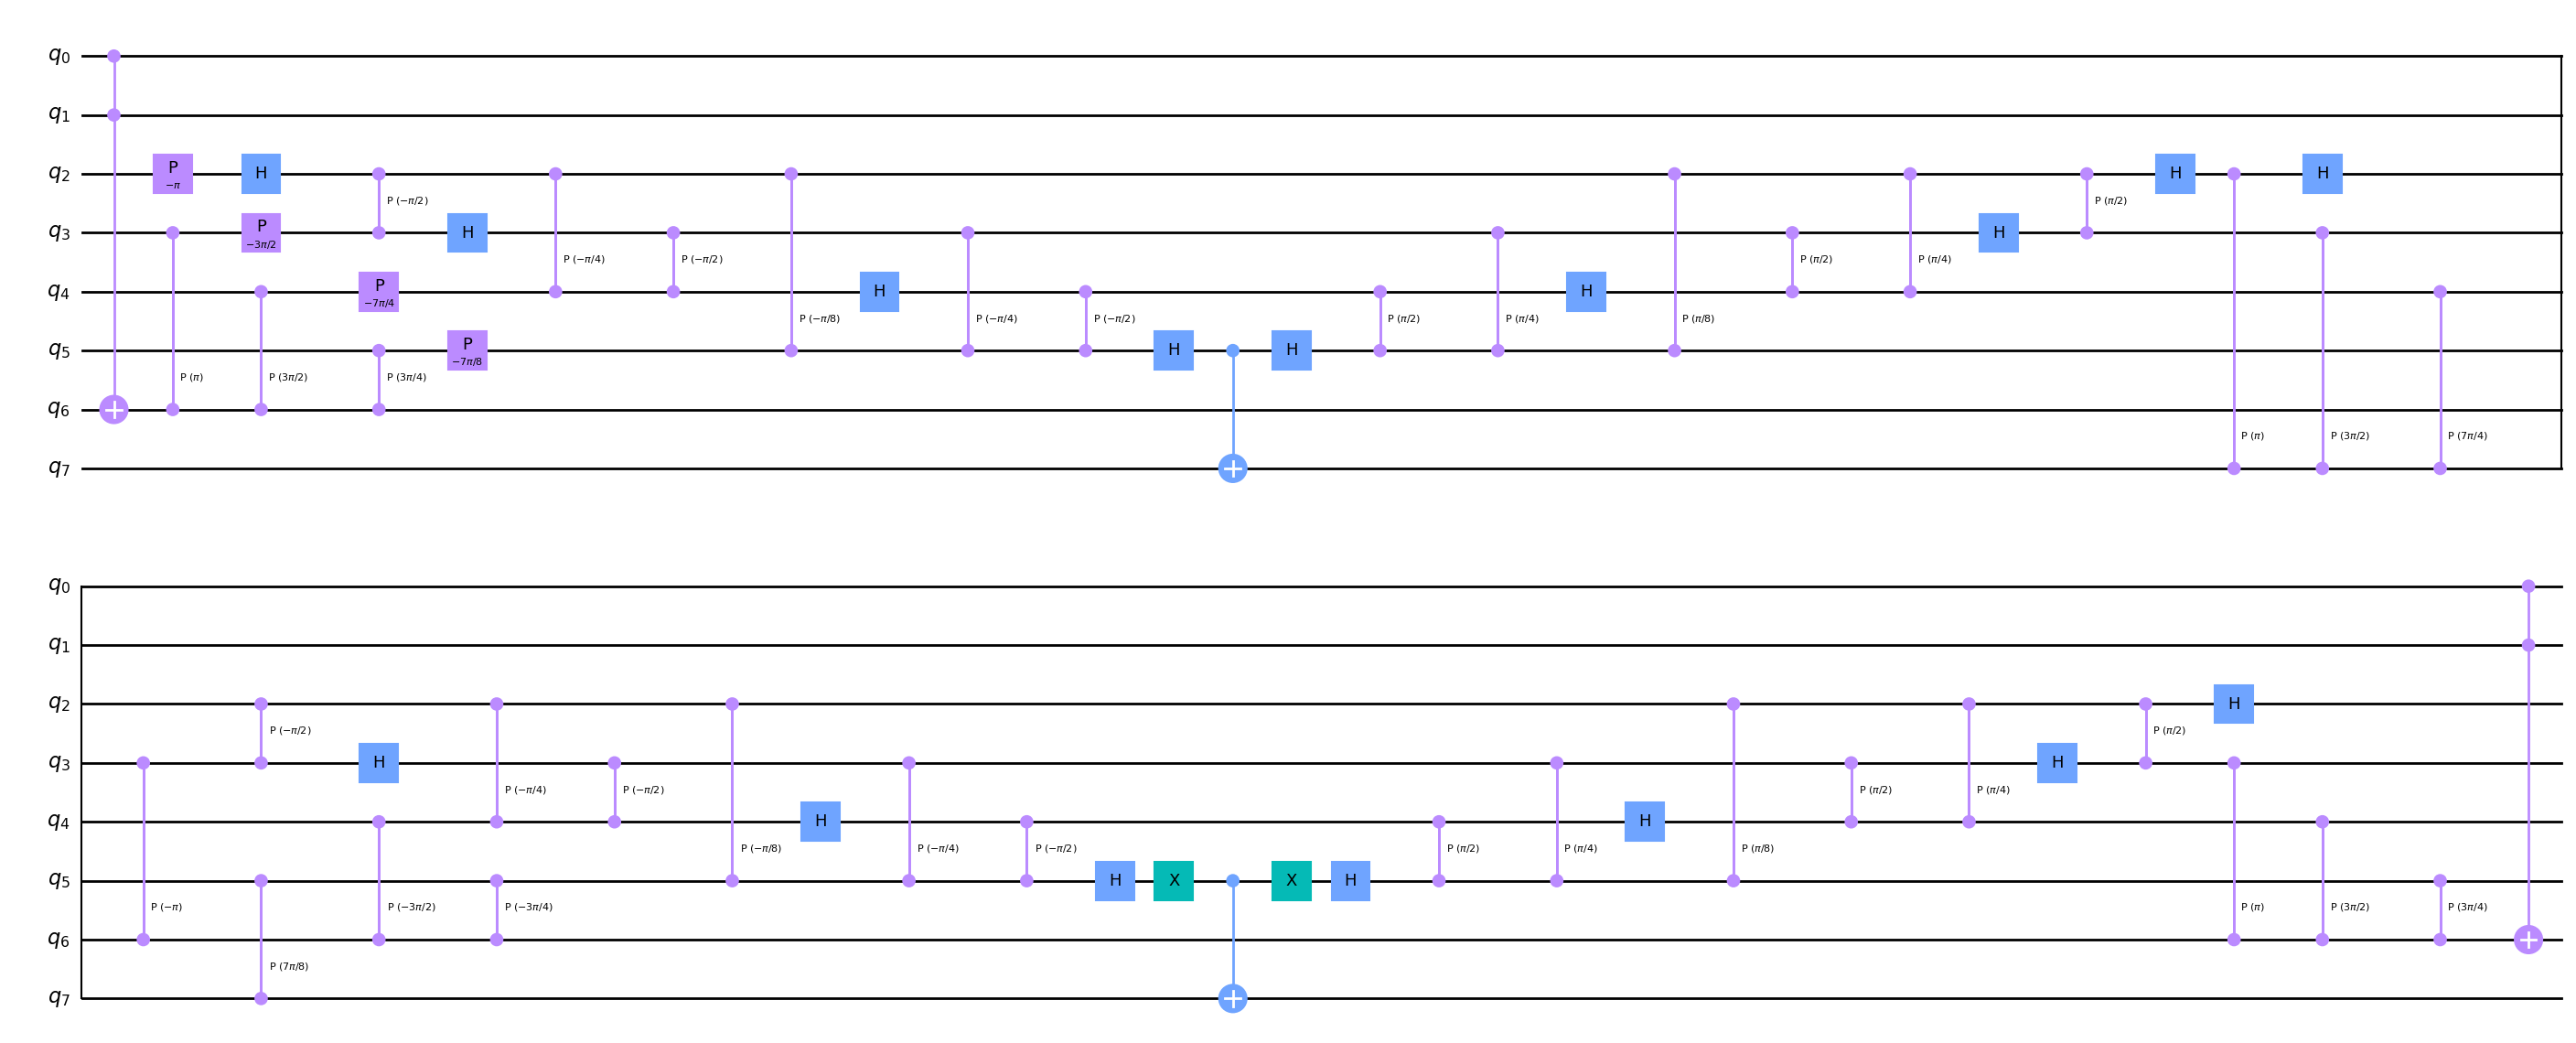

In [10]:
# Fix the N
EXAMPLE_N = 7
# Find the minimum number of bits required to represent N
n = bit_size_of(EXAMPLE_N)
# Register for integer b, of size n+1 because it will contains a+b in the end, which can be 1 bit longer than a and b
# Register b follows reg_a and therefore is offset by the len of reg_a
q_ctrl1 = 0
q_ctrl2 = 1
reg_b = [*range(2, 2 + n + 1)]
# Qubit q_t, which follows all the other register so its number is simply the combined length of the 4 registers
anciliaries = [*range(2 + len(reg_b) + 0, 2 + len(reg_b) + 2)]

# Display the resulting circuit
display(f"q_cctrl_adder_modN(N={EXAMPLE_N}):")
display(braket_to_qiskit_circuit(q_cctrl_adder_modN(EXAMPLE_N, 2**n-2, q_ctrl1, q_ctrl2, reg_b, anciliaries), True).draw('mpl', fold=42))

## Controlled Multiplication modulo N circuit

In [11]:
@circuit.subroutine(register=True)
def q_ctrl_mult_modN(
    N: int, m: int,
    q_ctrl: Qubit,
    reg_z: QubitSetInput,
    reg_b: QubitSetInput,
    anciliaries: QubitSetInput,
    reverse = False
) -> Circuit:
    """
    Construct a circuit object, that will become our generic Gate for modular multiplication of a qubit register by a classically known integer.
    At the end of this circuit, reg_b contains b + (z * m) % N if q_ctrl is 1 (else it does not change) and is the only register changed by the computation.
    Args:
        N (int): The number N, used to hard-code some part of the circuit, in particular the q_cctrl_adder_modN
        m (int): The number m, used to hard-code some part of the circuit and in particular to
            create the appropriate number of q_cctrl_adder_modN to perform (z * m) % N
        q_ctrl (Qubit): Control qubit used that control weither or not we perform the operations. In the grand
            scheme of things, this q_ctrl will be part of a larger register reg_x that will be introduced later.
        reg_z (QubitSetInput): Register of the number z, contains the integer z that we want to multiply,
            will be left unchanged at the end of the computation
        reg_b (QubitSetInput): Register of the number b, contains |b> at the begining of the circuit 
            and will contain |(b + (z * m)) % N> at the end of the computation if q_ctrl is 1, else it will be left unchanged.
        anciliaries (QubitSetInput): Register storing intermediate results, expected to be |0>
            at the begining of the circuit and will be left unchanged at the end
        reverse (bool): Create a reversed version of this circuit
    Returns:
        Circuit: Resulting circuit that can be used as a Gate in a more complex circuit
    """
    # The number of bit required to represent N
    n = bit_size_of(N)
    # B should always be n+1
    assert len(reg_b) == n + 1
    # reg_z should always be size n
    assert len(reg_z) == n
    # We need 2 anciliaries for this circuit
    assert len(anciliaries) == 2
    
    c = Circuit()
    
    # Inverse or not, qft is always the first gate in order to put reg_b in the Fourier space
    c.qft(reg_b, do_swaps=False)
    
    if not reverse:
        # We want to perform a serie of additions modulo N so that, in the end, reg_b = z * m % N
        # Of course, we could simply perform m-time the addition reg_b = reg_b + z, with reg_b initially at 0
        # But that would introduce an additionnal linear complexity O(m). If m is reasonnably large, it would be a problem...
        # But most of all, it is not needed.
        #
        # What we can do is use the following facts:
        # 1/
        # If z is an integer with a binary representation zn...z2z1z0, then
        # z*m = zn*2^n*m + ... + z2*2^2*m + z1*2^1*m + z0*2^0*m
        # It is just a formal way of saying a very obvious thing that you can easily see with a base-10 example:
        # 1873*m = 1000*m + 800*m + 70*m + 3*m = 1*10^3*m + 8*10^2*m + 7*10^1*m + 3*10^0*m
        # 2/
        # And of course: (A + B + C + D) % N = (((A % N + B % N) % N + C % N) % N + D % N) % N ; meaning that 
        # we can apply the modulo N as we go to each individual addition and operand, and obtain exactly the same result
        # as if we were to first perform the complete addition and then apply the modulo.

        # So we use these facts to optimize our circuit. Instead of performing m-time the q_adder_modN, we only need bit_size(z) q_adder_modN

        # For each qubit of the register z
        for i in range(len(reg_z)):
            # Compute the value of (2^j * m) % N
            m2imodN = (2**i * m) % N
            # Perform the addition controlled by the appropriate reg_z bit (and q_ctrl)
            c.q_cctrl_adder_modN(N, m2imodN, q_ctrl, reg_z[i], reg_b, anciliaries)

    else:
        for i in reversed(range(len(reg_z))):
            # Compute the value of (2^j * m) % N
            m2imodN = (2**i * m) % N
            # Perform the addition controlled by the appropriate reg_z bit (and q_ctrl)
            c.q_cctrl_adder_modN(N, m2imodN, q_ctrl, reg_z[i], reg_b, anciliaries, reverse=True)

    # Inverse or not, qft-dagger is always the last gate in order to put reg_b back in the computational basis
    c.qft(reg_b, reverse=True, do_swaps=False)
    return c


In [12]:
N = 7
MAX_TESTS=10
# The base size n of the registers is the minimum number of bits required to represent N
n = bit_size_of(N)
# Register for integer z, of size n
reg_z = [*range(0, n)]
# Register for integer b, of size n + 1
reg_b = [*range(len(reg_z) + 0, len(reg_z) + n + 1)]
# ancilliaries
anciliaries = [*range(len(reg_z) + len(reg_b) + 0, len(reg_z) + len(reg_b) + 2)]
# q_ctrl
q_ctrl = len(reg_z) + len(reg_b) + len(anciliaries)

for m in range(N+1):
    for z in range(N+1):
        # Create the circuit
        c = Circuit()
        # Apply a not-not (which does nothing) to all qubits
        # This is because braket only knows a qubit exist in the circuit if it sees it at least once
        # so we have to do that for our test, else in some case it will complain that we gave it non-contiguous qubits
        c.x(reg_z + reg_b + anciliaries)
        c.x(reg_z + reg_b + anciliaries)
        # Set q_ctrl to |1>
        c.x(q_ctrl)
        # Set reg_z = z, using the usual method
        for i in range(n):
            # If the i-th bit in the integer z is 1
            if 2**i & z:
                # Flip the corresponding qubit in reg_z with a not-gate (thus changing it from 0 (the default) to 1)
                c.x(reg_z[i])
        
        # Create the modular exponentiation
        c.q_ctrl_mult_modN(N, m, q_ctrl, reg_z, reg_b, anciliaries)
        # Simulates 1000 shots
        measures = local_simulator.run(c, shots=1000).result().measurement_counts.keys()
        # There should only be one result because this circuit should be completly deterministic
        assert len(measures) == 1, f"Expected only one result, got {len(measures)}: {measures}"
        for measure in measures:
            # Extract from the measurement the value of reg_z
            result = int(''.join(reversed(measure[len(reg_z):len(reg_z) + len(reg_b)])), 2)
            expected = (z*m) % N
            assert expected == result, f"({z}*{m}) % {N} = {expected} not {result}"

display("q_ctrl_mult_modN behave as expected")

'q_ctrl_mult_modN behave as expected'

## Modular Exponentiation circuit
At the begining, `reg_z = |1>` and in the end `reg_z = |y^x mod N>`

All the other registers are returned back to their original value, which is expected to be `|0>`

In [13]:
@circuit.subroutine(register=True)
def modular_exponentiation_ymodN(
    N: int, y: int,
    reg_x: QubitSetInput,
    reg_z: QubitSetInput,
    reg_b: QubitSetInput,
    anciliaries: QubitSetInput,
) -> Circuit:
    """
    Construct a circuit object, that will become our generic Gate for modular exponentiation.
    At the end of this circuit, reg_z contains |(y^x) % N> and is the only register changed by the computation.
    Args:
        N (int): The number N, used to hard-code some part of the circuit
        y (int): The number y that we elevate to power x (contained in reg_x), used to hard-code some part
            of the circuit
        reg_x (QubitSetInput): Register of the number x, contains |x>, the power at which
            we want to elevate y and will be left unchanged at the end of the computation
        reg_z (QubitSetInput): Register of the number z, contains |1> initially and |y^x % N> at the end of the computation
        reg_b (QubitSetInput): Register of the number b, expected to be |0> at the begining of the circuit 
            and will be left unchanged at the end of the computation
        anciliaries (QubitSetInput): Register storing intermediate results, expected to be |0>
            at the begining of the circuit and will be left unchanged at the end
    Returns:
        Circuit: Resulting circuit that can be used as a Gate in a more complex circuit
    """
    # The number of bit required to represent N
    n = bit_size_of(N)
    # B should always be n+1
    assert len(reg_b) == n + 1
    # reg_z should always be size n
    assert len(reg_z) == n
    # We need 2 anciliaries for this circuit
    assert len(anciliaries) == 2
    # Reg_x can technically be any length
    assert len(reg_x) > 0
    
    c = Circuit()
    
    # We want to compute y^x % N, that is the modular exponentiation of y to the power of x.
    # Then again, we could simply multiply reg_z (which is 1) by y x-time, but we will do better
    # If x is a binary number xn...x2x1x0, then:
    # y^x = y^(xn*2^n + ... + x2*2^2 + x1*2^1 + x0*2^0)
    # And we know that y^(a + b) = y^a * y^b ; so
    # y^x = y^(xn*2^n) *  ... * y^(x2*2^2) * y^(x1*2^1) * y^(x0*2^0)
    # Therefore the exponantiation can be translated into a serie of multiplication:
    # Starting from the initial value 1, we multiply successively by y^(xn*2^n), which is y^(2^n) if xn is 1, and 1 if xn = 0
    #
    # It should also be noted that (A * B) % N = ((A % N) * (B % N)) % N, therefore we can apply the modulo as we go for each operand and multiplication
    # without changing the final result

    # In the following loop, every operation is controlled by the i-th qubit of reg_x
    # I explain what's going on assuming this i-th qubit is 1
    # If it happens to be 0, the whole iteration does absolutly nothing so there is nothing to explain
    # For each qubit index of the register x
    for i in range(len(reg_x)):
        # Compute m = y^(2^i) % N
        # The expression bellow is the easy way of computing what we want
        # m = (y**(2**i)) % N
        # But it is very inefficient in Python, so we help him by computing the value by successive squaring
        m = y
        for _garbage in range(i): m = m*m % N
        # Perform a q_ctrl_mult_modN by m, controlled by the i-th qubit of x.
        # Essentially we multiply by y^(2^i) if xi is 1, or we do nothing if xi is 0
        c.q_ctrl_mult_modN(N, m, reg_x[i], reg_z, reg_b, anciliaries)
        # At this point, if xi is 1, reg_b contains (m * z) % N
        # If xi is 1, we swap the content of reg_z and reg_b
        # We do that with a controled-swap operation for each qubit of reg_z, controlled by xi
        for j in range(len(reg_z)):
            c.cswap(reg_x[i], reg_z[j], reg_b[j])
        # If xi is 1, reg_z and reg_b are now inversed so we essentially saved the result (m * z) % N that was in reg_b into reg_z
        # leaving reg_b with the initial value of reg_z from the previous iteration
        # The goal here is to revert b to 0 so it is usable for the next iteration (the next q_ctrl_mult_modN)
        # To do that we compute modular_inverse_of_m as the modular inverse of m modulo N
        # By definition, (m * modular_inverse_of_m) % N = 1
        modular_inverse_of_m = pow(m, -1, N)
        # We use this modular_inverse_of_m to perform the reverse q_ctrl_mult_modN
        c.q_ctrl_mult_modN(N, modular_inverse_of_m, reg_x[i], reg_z, reg_b, anciliaries, reverse=True)
        # Why does it work?
        # For each iteration (assuming the i-th qubit of reg_x is 1 and we do something), here is what happens.
        # Initially we have:
        #   reg_z = |z>
        #   reg_b = |0>
        # After performing the q_ctrl_mult_modN multiplying by m:
        #   reg_z = |z>
        #   reg_b = |(z * m) % N>
        # After swaping the registers z and b:
        #   reg_z = |(z * m) % N>
        #   reg_b = |z>
        # We recognize that this is the situation we would have IF we had applied a q_ctrl_mult_modN using modular_inverse_of_m instead of m,
        # with reg_b = |0> initially because by definition:
        # (((z * m) % N) * modular_inverse_of_m) % N = (z * (m * modular_inverse_of_m % N)) % N = (z * 1) % N = z
        # Therefore performing reverse-q_ctrl_mult_modN with modular_inverse_of_m will set back reg_b to 0 (and left reg_z untouched, as usual)

    return c

In [14]:
# Controls that the circuit is actually performing correctly for some possible values MOD N

# Choose N
# Carreful, the qubit count Q = 2n + 1 + 2 + 2
# And the complexity of simulating Quantum circuits is O(2^Q)
# It goes up very, very quickly
# Chosing N = 15 means n=4 and Q=13 qubits
# With N = 7, n=3, Q=11, which should take few seconds
N = 7
MAX_TESTS=10
# The base size n of the registers is the minimum number of bits required to represent N
n = bit_size_of(N)
# The register x can technically be any size we want, but for this test we will take a 2-sized register
reg_x = [*range(2)]
# Register for integer z, of size n
# It follows the previous registers and therefore is offset by their cumulated lenght
reg_z = [*range(len(reg_x) + 0, len(reg_x) + n)]
# Register for integer b, of size n + 1 because at some point it must hold a+b, which can be 1-bit longer than a and b
# It follows the previous registers and therefore is offset by their cumulated lenght
reg_b = [*range(len(reg_x) + len(reg_z) + 0, len(reg_x) + len(reg_z) + n + 1)]
# Register for anciliaries, of size 2
# It follows the previous registers and therefore is offset by their cumulated lenght
anciliaries = [*range(len(reg_x) + len(reg_z) + len(reg_b) + 0, len(reg_x) + len(reg_z) + len(reg_b) + 2)]

# Test y^x mod N for various random values of x and y
# Generate all the values of y so that y is prime with N, GCD(y,N)=1
all_ys = [y for y in range(2, N) if math.gcd(y,N) == 1]
# Multiply that with the possible value for x, taken between 1 and N included
possible_tests = [(y, x) for x in range(2**len(reg_x)) for y in all_ys]
display(f"There are {len(possible_tests)} possible tests, taking at most {MAX_TESTS} of them at random")
tests = sample(possible_tests, min(len(possible_tests), MAX_TESTS))
# Perform at most MAX_TESTS tests
test_number=0
for y, x in tests:
    test_number+=1
    display(f"Test #{test_number} building Modular exponentiation for: ({y}^{x}) % {N}")
    # Create the circuit
    c_modular_exponentiation_ymodN = Circuit()
    # As usual, explicitly "initialize" everything to 0 so that Braket does not complain in some edge cases
    c_modular_exponentiation_ymodN.x(reg_x + reg_z + reg_b + anciliaries)
    c_modular_exponentiation_ymodN.x(reg_x + reg_z + reg_b + anciliaries)
    
    # Set reg_z = |1>
    c_modular_exponentiation_ymodN.x(reg_z[0])

    # Set reg_x = |x>, using the usual method
    for i in range(n):
        # If the i-th bit in the integer x is 1
        if 2**i & x:
            # Flip the corresponding qubit in reg_x with a not-gate (thus changing it from 0 (the default) to 1)
            c_modular_exponentiation_ymodN.x(reg_x[i])

    # Create the modular exponentiation
    c_modular_exponentiation_ymodN.modular_exponentiation_ymodN(N, y, reg_x, reg_z, reg_b, anciliaries)
    display(f"Running 1000 shots...")
    # Simulates 1000 shots
    measures = local_simulator.run(c_modular_exponentiation_ymodN, shots=1000).result().measurement_counts.keys()
    # There should only be one result because this circuit should be completly deterministic
    assert len(measures) == 1, f"Expected only one result, got {len(measures)}: {measures}"
    for measure in measures:
        display(f"measure={measure}")
        # Extract from the measurement the value of reg_z
        result = int(''.join(reversed(measure[len(reg_x):len(reg_x) + len(reg_z)])), 2)
        expected = (y**x) % N
        display(f"({y}^{x}) % {N} = {result}")
        assert expected == result, f"({y}^{x}) % {N} = {expected} not {result}"
    display("")

'There are 20 possible tests, taking at most 10 of them at random'

'Test #1 building Modular exponentiation for: (3^1) % 7'

'Running 1000 shots...'

'measure=10110000000'

'(3^1) % 7 = 3'

''

'Test #2 building Modular exponentiation for: (5^1) % 7'

'Running 1000 shots...'

'measure=10101000000'

'(5^1) % 7 = 5'

''

'Test #3 building Modular exponentiation for: (4^1) % 7'

'Running 1000 shots...'

'measure=10001000000'

'(4^1) % 7 = 4'

''

'Test #4 building Modular exponentiation for: (2^0) % 7'

'Running 1000 shots...'

'measure=00100000000'

'(2^0) % 7 = 1'

''

'Test #5 building Modular exponentiation for: (2^1) % 7'

'Running 1000 shots...'

'measure=10010000000'

'(2^1) % 7 = 2'

''

'Test #6 building Modular exponentiation for: (6^0) % 7'

'Running 1000 shots...'

'measure=00100000000'

'(6^0) % 7 = 1'

''

'Test #7 building Modular exponentiation for: (6^2) % 7'

'Running 1000 shots...'

'measure=01100000000'

'(6^2) % 7 = 1'

''

'Test #8 building Modular exponentiation for: (3^0) % 7'

'Running 1000 shots...'

'measure=00100000000'

'(3^0) % 7 = 1'

''

'Test #9 building Modular exponentiation for: (5^0) % 7'

'Running 1000 shots...'

'measure=00100000000'

'(5^0) % 7 = 1'

''

'Test #10 building Modular exponentiation for: (6^3) % 7'

'Running 1000 shots...'

'measure=11011000000'

'(6^3) % 7 = 6'

''

In [15]:
EXAMPLE_N=15
EXAMPLE_Y=4
# The base size n of the registers is the minimum number of bits required to represent N
n = bit_size_of(EXAMPLE_N)
# The register x can technically be any size we want, but for this test we will take a 2-sized register
reg_x = [*range(2)]
# Register for integer z, of size n
# It follows the previous registers and therefore is offset by their cumulated lenght
reg_z = [*range(len(reg_x) + 0, len(reg_x) + n)]
# Register for integer b, of size n + 1 because at some point it must hold a+b, which can be 1-bit longer than a and b
# It follows the previous registers and therefore is offset by their cumulated lenght
reg_b = [*range(len(reg_x) + len(reg_z) + 0, len(reg_x) + len(reg_z) + n + 1)]
# Register for anciliaries, of size 2
# It follows the previous registers and therefore is offset by their cumulated lenght
anciliaries = [*range(len(reg_x) + len(reg_z) + len(reg_b) + 0, len(reg_x) + len(reg_z) + len(reg_b) + 2)]
display(f"modular_exponentiation_ymodN(N={EXAMPLE_N}):")
display(braket_to_qiskit_circuit(modular_exponentiation_ymodN(EXAMPLE_N, EXAMPLE_Y, reg_x, reg_z, reg_b, anciliaries), True).draw('mpl', fold=212))

'modular_exponentiation_ymodN(N=15):'

# Create the Shor's circuit for a, N

In [16]:
def shors_algorithm(reg_x_size: int, integer_N: int, integer_a: int) -> Circuit:
    """
    Creates the circuit for Shor's algorithm.
      1) Setup auxiliary registers and apply modular exponentiation with counting qubits as the exponent
      2) Apply inverse_QFT on counting qubits
    Args:
        reg_x_size (int) : The size of the register reg_x
        integer_N (int) : The integer N to be factored
        integer_a (int) : Any integer 'a' that satisfies 1 < a < N and gcd(a, N) = 1.
    Returns:
        Circuit: Circuit object that implements the Shor's algorithm
    """

    # validate the inputs
    if integer_N < 1 or integer_N % 2 == 0:
        raise ValueError("The input N needs to be an odd integer greater than 1.")
    if integer_a <= 1 or integer_a >= integer_N or math.gcd(integer_a, integer_N) != 1:
        raise ValueError('The integer "a" needs to satisfy 1 < a < N and gcd(a, N) = 1.')

    # calculate n, the number of qubits needed to store N
    n = bit_size_of(integer_N)

    # The register x can technically be any size we want,
    # but in order to obtain sufficient precision for recovering the order of integer_a, we need x to be at least of size 2n
    # 
    # integer_a is part of ZN-star, which are the numbers a in {0, 1, ..., N-1} so that gcd(a, N) = 1,
    # so there must exist r, such that integer_a^r = 1 % N ; r is called the order of integer_a modulo N
    # We want to retrieve it because it can allow us to factor N, given some additionnal conditions (see further)
    reg_x = [*range(reg_x_size)]
    # Register for integer z, of size n
    # It follows the previous registers and therefore is offset by their cumulated length
    reg_z = [*range(len(reg_x) + 0, len(reg_x) + n)]
    # Register for integer b, of size n + 1 to control the overflow of the modular addition
    # It follows the previous registers and therefore is offset by their cumulated length
    reg_b = [*range(len(reg_x) + len(reg_z) + 0, len(reg_x) + len(reg_z) + n + 1)]
    # anciliary qubits, which follows all the other registers and therefore is offset by their cumulated length
    anciliaries = [*range(len(reg_x) + len(reg_z) + len(reg_b) + 0, len(reg_x) + len(reg_z) + len(reg_b) + 2)]
    
    # Create a circuit
    shors_circuit = Circuit()

    # Initialize registers
    # All qubits in register reg_x are put in superposition by Hadamar
    # Essentially it can be intuited as making the circuit compute a^x % N for every possible value of x simultaneously
    # Which is the basic advantage of quantum computing, and the central one for Shor's algorithm
    shors_circuit.h(reg_x)
    
    # Register z is initialized to |1>
    shors_circuit.x(reg_z[0])

    # We apply the modular exponentiation a^x ; with x being in superposition
    shors_circuit.modular_exponentiation_ymodN(integer_N, integer_a, reg_x, reg_z, reg_b, anciliaries)
    # This will kickback the phase of the multiplication by a into x, thus allowing us to retrieve an estimation of this phase
    # Apply inverse QFT on x to retrieve an estimation of the phase
    shors_circuit.qft(reg_x, reverse=True)
    # Now reg_x contains |y> with y/2^size_of(x) = j/r for some unknown j. Recall that r is the order of integer_a modulo N, which is what we are looking for
    # For more details, you need to explore very precisely how Shor's algorythm works. It's not easy.
    # But the number theory connecting r to the factors of N is pretty easy to understand.

    return shors_circuit


# Display Shor's circuit with Qiskit

In [19]:
# reg_x size is 8 qubits
# N (to factor) = 15
# a (randomly choosen) = 11
circuit = shors_algorithm(8, 15, 11)
display(f"circuit_depth = {circuit.depth}")
display(braket_to_qiskit_circuit(circuit).draw('mpl', fold=503, scale=0.8))

'circuit_depth = 3237'

# Create a bunch of helper functions

Like a function to run a `circuit` on a `device`, computing the values for `j/r` and trying to recover `r`, and so on and so forth

In [22]:
def run_shors_circuit(
    circuit: Circuit,
    device: Device,
    shots: Optional[int] = 1000,
) -> Dict[str, int]:
    """
    Function to run Shor's algorithm and return measurement counts.
    Args:
        circuit (Circuit): Shor's algorithm circuit
        device (Device): Braket device backend
        shots (Optional[int]) : Number of measurement shots (default is 1000).
            0 shots results in no measurement.
    Returns:
        Dict[str, Any]: measurements and results from running Shors's algorithm
    """

    task = device.run(circuit, shots=shots)

    while task.state() != 'COMPLETED':
        sleep(5)
    display(f"[{datetime.now()}] Simulation COMPLETED!")
        
    result = task.result()

    measurement_counts = result.measurement_counts
    measurement_counts = {
        key: measurement_counts[key]
        for key in sorted(
            list(measurement_counts.keys()),
            key=lambda o:measurement_counts[o],
            reverse=True
        )
    }

    return measurement_counts

def split_registers(
    results: Dict[str, int],
    reg_x_size: int,
    n: int,
) -> List[Dict[str, Any]]:
    """
    Function to postprocess dictionary returned by run_shors_algorithm
        and recover the content of each register
    Args:
        results (Dict[str, int]): Measurement produced by run_shors_algorithm
        reg_x_size (int): the number of qubits of reg_x
        n (int) : the number of qubits of the other registers (except reg_b that we know will have size n+1)
    Returns:
        Dict[int, Dict[str, str]] : 
    """
    result_splitted = [
        {
            'reg_x': key[:reg_x_size],
            'reg_z': key[reg_x_size:reg_x_size+n],
            'reg_b': key[reg_x_size+n:reg_x_size+2*n+1],
            'ancilliaries': key[reg_x_size+2*n+1:],
            'count': count
        }    
        for key, count in results.items()
    ]
    
    return result_splitted

def get_phases(reg_x_counts: Dict[str, int]) -> List[float]:
    """
    Get phase estimate from measurement_counts using reg_x qubits
    Args:
        reg_x_counts (Dict[str, int]) : reg_x values with the number of time they occured
    Returns:
        List[float] : Phase estimates, ordered by likelihood
    """
    
    # Reg_x all has the same size
    k_sizes = [len(k) for k in reg_x_counts.keys()]
    assert min(k_sizes) == max(k_sizes)

    phase_precision = 2**min(k_sizes)
    # Each phase estimate is reg_x / 2^reg_x_size
    phases_decimals = [
        (int(''.join(reversed(item)), 2) / phase_precision, reg_x_counts[item])
        for item in sorted(
            list(reg_x_counts.keys()),
            key=lambda o:reg_x_counts[o],
            reverse=True
        )
    ]
    display(f"[{datetime.now()}] phases_decimals={phases_decimals}")

    return phases_decimals

def get_factors_from_results(
    splitted_results: List[Dict[str, Any]],
    integer_N: int,
    integer_a: int,
) -> List[int]:
    """
    Function to postprocess dictionary returned by run_shors_algorithm
        and pretty print results
    Args:
        splitted_results (List[Dict[str, Any]]): Measurement produced by run_shors_algorithm and post-processed
        reg_x_size (int): the number of qubits of reg_x
        integer_N (int) : The integer to be factored
        integer_a (int) : Any integer that satisfies 1 < a < N and gcd(a, N) = 1.
        verbose (bool) : If True, prints aggregate results (default is False)
    Returns:
        Dict[str, Any]: Factors of the integer N
    """

    # Agglomerate reg_x
    reg_x_counts = {}
    for splitted_result in splitted_results:
        k = splitted_result['reg_x']
        reg_x_counts[k] = reg_x_counts.get(k, 0) + splitted_result['count']
    
    # get phases
    phases_decimals = get_phases(reg_x_counts)
    # r values
    r_values = {}
    for phase, count in phases_decimals:
        # Each phase yield by the Shor algorithm is phase = j/r ; with j an unknown random value and r the number we are looking for (order of a modulo N)
        # We find the best fraction u/v that approximate the phase using the continued fraction algorithm
        # There is good chances that u/v = j/r ; but it could happen that j and r share factors so in that case u != j and v != r.
        #
        # For example, imagine the correct r is r = 4.
        # If we happen to retrieve the phase for a value j=2, then we have phase = 0.5 and the continued fraction algorithm
        # will yield 1/2. We will register 2 as our r candidate, which is wrong.
        # On the other hand, if we happen to retrieve the phase for a value j=3, then we have phase = 0.75 and the continued fraction algorithm will
        # yield 3/4. We will then register 4 as our r candidate, which is right.
        # It also would work if we retrieve the phase for j=1
        # If we are unlucky and retrieve phase = 0 (for j=0), we do not learn anything because r can have any value in that case: 0 / r = 0, no matter the value of r.
        r = (Fraction(phase).limit_denominator(integer_N)).denominator
        # Accumulate the counts
        r_values[r] = r_values.get(r, 0) + count
    r_values_list = [
        r
        for r in sorted(
            list(r_values.keys()),
            key=lambda o:r_values[o],
            reverse=True
        )
    ]
    
    factors = []
    for r in r_values_list:
        display(f"[{datetime.now()}] r = {r} (count={r_values[r]})")
        if integer_a**r % integer_N != 1:
            display(f"[{datetime.now()}] a**r % N != 1. r is not the order of a modulo N :'( Skipping to the next r candidate discovered")
            continue
        if r % 2 != 0:
            display(f"[{datetime.now()}] r is odd :'( Skipping to the next r candidate discovered")
            continue
        f = [
            math.gcd(integer_a ** (r // 2) - 1, integer_N),
            math.gcd(integer_a ** (r // 2) + 1, integer_N),
        ]
        display(f"[{datetime.now()}] factors discovered with this r: {f}")
        factors.append(f[0])
        factors.append(f[1])
    # Create a set of unique factors
    factors_set = set(factors)
    # Discard trivial factors
    factors_set.discard(1)
    factors_set.discard(integer_N)
    # Retrun what we are left with
    return list(factors_set)

def run_shors_algo(integer_N: int, device: Device, override_x_size = None) -> tuple[int, int]:
    """
    Find the factors of integer_N using device to run the Quantum Circuit
    Args:
        integer_N (int) : The integer to be factored
        device (Device): Braket device backend
        override_x_size (Optional[int]) : Override the size of the X register with the given size
    Returns:
        (int, int): returns p and q such as p * q = N
    """
    # Find a random a such as 1 < a < N and a is coprime with N (meaning that a belong in the set ZN-star)
    integer_a = randint(2, integer_N - 1)
    display(f"[{datetime.now()}] a = {integer_a}")
    
    # If a is not co-prime with N, it means that a is a factor of either p or q because N = p * q with p and q being primes
    # therefore we already won!
    # Of course, in real life with log2(N)>1024, there is absolutely NO CHANCE to stumble upon the solution like that
    gcd_aN = math.gcd(integer_a, integer_N)
    if gcd_aN != 1:
        # We cannot believe our luck, we found either p or q
        p = gcd_aN
        q = integer_N//p
        display(f"[{datetime.now()}] How lucky!! {integer_N} = {p} * {q}")
        return (p, q)
    
    # This security is only do-able if N is small
    # It is not an official part of Shor's procedure for fartorization
    # Nonetheless, around 50% of the a you choose will be worthless
    # So with small N, we verify which a are usefull and wich ones are not in order to avoid useless simulations
    if integer_N < 512:
        # Because the simulation is expensive, we will cheat and eliminate values of a that we KNOW cannot work
        # as we are using small integers for demonstration, we can of course trivially compute all the possible outcomes
        ZNstar = [a for a in range(2, integer_N) if math.gcd(a, integer_N) == 1]
        excluded_a_order_odd = []
        excluded_a_trivial_factors = []
        for a in ZNstar:
            # Find the order of a modulo N
            r = 1
            while a**r % integer_N != 1:
                r += 1
            # If r is not even, it will be unusable
            if r % 2 != 0:
                excluded_a_order_odd.append(a)
                continue
            # If r is even, it can happen that it yields only trivial factors
            factors = [
                math.gcd(a**(r // 2) - 1, integer_N),
                math.gcd(a**(r // 2) + 1, integer_N),
            ]
            factors_set = set(factors)
            # Discard trivial factors
            factors_set.discard(1)
            factors_set.discard(integer_N)
            if len(factors_set) == 0:
                excluded_a_trivial_factors.append(a)

        display(f"[{datetime.now()}] For N={integer_N}, ZNstar={ZNstar}")
        display(f"[{datetime.now()}] For N={integer_N}, values of a in ZNstar that cannot work because their order is odd: {excluded_a_order_odd}")
        display(f"[{datetime.now()}] For N={integer_N}, values of a in ZNstar that cannot work because their order yield trivial factors: {excluded_a_trivial_factors}")
        display(f"[{datetime.now()}] For N={integer_N}, values of a that will work: {[a for a in ZNstar if a not in excluded_a_order_odd and a not in excluded_a_trivial_factors]}")

        if integer_a in excluded_a_order_odd:
            display(f"[{datetime.now()}] Discarding a={integer_a} because we know it will be a waste of time. Its order is odd. Try again!")
            return None
        if integer_a in excluded_a_trivial_factors:
            display(f"[{datetime.now()}] Discarding a={integer_a} because we know it will be a waste of time. Its order yields only trivial factors. Try again!")
            return None

    # Create the circuit
    # reg_x_size will be the 2*n, with n the minimum number of bits required to encode N
    n = bit_size_of(integer_N)
    reg_x_size = n * 2
    if override_x_size is not None:
        reg_x_size = override_x_size
    shors_circuit = shors_algorithm(reg_x_size, integer_N, integer_a)
    display(f"[{datetime.now()}] circuit_qubit_count = {shors_circuit.qubit_count}")
    display(f"[{datetime.now()}] circuit_depth = {shors_circuit.depth}")
    
    # If the circuit is too big, don't try to run it
    if shors_circuit.qubit_count >= 31:
        display(f"[{datetime.now()}] Qubit count is too high for a simulation")
        return None

    # Run the circuit
    results = run_shors_circuit(shors_circuit, device, 1000)
    display(f"[{datetime.now()}] results_from_shor = {results}")
    splitted_results = split_registers(results, reg_x_size, n)
    display(f"[{datetime.now()}] splitted_results_from_shor = {splitted_results}")
    factors = get_factors_from_results(splitted_results, integer_N, integer_a)
    display(f"[{datetime.now()}] factors_from_shor = {factors}")
    if len(factors) == 2:
        p, q = factors
    elif len(factors) == 1:
        p = factors[0]
        q = integer_N//p
    else:
        display(f"[{datetime.now()}] Failed to found factors, try again!")
        return None
    
    display(f"[{datetime.now()}] {integer_N} = {p} * {q}")
    return (p, q)

# Generate a list of possible N to factor

In [23]:
# Maximum bitsize of N
# The circuit will have 4n+3 qubits so 7 is the limit of what is classically computable with modest resources
MAX_SIZE_OF_N = 7

# Find all primes up to 100000
primes = []
for p in range(3, 100000, 2):
    p_is_prime = True
    sqrt_p = int(math.sqrt(p)) + 1
    for q in primes:
        if q > sqrt_p:
            break
        if p % q == 0:
            p_is_prime = False
            break
    if p_is_prime:
        primes.append(p)

# Find the upper bound of N so that its bit-size stays under or equal MAX_SIZE_OF_N
max_N=2**MAX_SIZE_OF_N-1
# Get all the N you could try to factor by multiplying 2 primes and taking all the results under max_N (and that are not squares)
possible_N = sorted(list(set([p * q for p in primes for q in primes if p != q and p * q <= max_N])))

print(possible_N)

[15, 21, 33, 35, 39, 51, 55, 57, 65, 69, 77, 85, 87, 91, 93, 95, 111, 115, 119, 123]


# Run Shor's algorithm on LocalBackend

It will cost nothing to do so and you can reasonnably do it for N so that size_of(N) <= 5 (which means a circuit of 23 qubits max).

If you want to try to factor bigger numbers, you need a really beefy computer or a super-computer

In [26]:
# Factor 15 on LocalSimulator
N = 15
run_shors_algo(N, local_simulator)

'[2023-11-16 09:56:45.876505] a = 13'

'[2023-11-16 09:56:45.877869] For N=15, ZNstar=[2, 4, 7, 8, 11, 13, 14]'

'[2023-11-16 09:56:45.878516] For N=15, values of a in ZNstar that cannot work because their order is odd: []'

'[2023-11-16 09:56:45.879495] For N=15, values of a in ZNstar that cannot work because their order yield trivial factors: [14]'

'[2023-11-16 09:56:45.880492] For N=15, values of a that will work: [2, 4, 7, 8, 11, 13]'

'[2023-11-16 09:56:47.912664] circuit_qubit_count = 19'

'[2023-11-16 09:56:47.913660] circuit_depth = 3236'

'[2023-11-16 09:57:53.169702] Simulation COMPLETED!'

"[2023-11-16 09:57:53.171696] results_from_shor = {'0000001110110000000': 75, '0000001010110000000': 73, '0000001011100000000': 71, '0000000110000000000': 70, '0000000010000000000': 66, '0000001110000000000': 64, '0000000110110000000': 63, '0000000011100000000': 62, '0000000010110000000': 60, '0000001100100000000': 60, '0000000111100000000': 59, '0000000100100000000': 59, '0000001010000000000': 57, '0000001111100000000': 57, '0000000000100000000': 52, '0000001000100000000': 52}"

"[2023-11-16 09:57:53.172693] splitted_results_from_shor = [{'reg_x': '00000011', 'reg_z': '1011', 'reg_b': '00000', 'ancilliaries': '00', 'count': 75}, {'reg_x': '00000010', 'reg_z': '1011', 'reg_b': '00000', 'ancilliaries': '00', 'count': 73}, {'reg_x': '00000010', 'reg_z': '1110', 'reg_b': '00000', 'ancilliaries': '00', 'count': 71}, {'reg_x': '00000001', 'reg_z': '1000', 'reg_b': '00000', 'ancilliaries': '00', 'count': 70}, {'reg_x': '00000000', 'reg_z': '1000', 'reg_b': '00000', 'ancilliaries': '00', 'count': 66}, {'reg_x': '00000011', 'reg_z': '1000', 'reg_b': '00000', 'ancilliaries': '00', 'count': 64}, {'reg_x': '00000001', 'reg_z': '1011', 'reg_b': '00000', 'ancilliaries': '00', 'count': 63}, {'reg_x': '00000000', 'reg_z': '1110', 'reg_b': '00000', 'ancilliaries': '00', 'count': 62}, {'reg_x': '00000000', 'reg_z': '1011', 'reg_b': '00000', 'ancilliaries': '00', 'count': 60}, {'reg_x': '00000011', 'reg_z': '0010', 'reg_b': '00000', 'ancilliaries': '00', 'count': 60}, {'reg_x': 

'[2023-11-16 09:57:53.174685] phases_decimals=[(0.75, 256), (0.25, 253), (0.5, 251), (0.0, 240)]'

'[2023-11-16 09:57:53.175682] r = 4 (count=509)'

'[2023-11-16 09:57:53.176679] factors discovered with this r: [3, 5]'

'[2023-11-16 09:57:53.177677] r = 2 (count=251)'

"[2023-11-16 09:57:53.178672] a**r % N != 1. r is not the order of a modulo N :'( Skipping to the next r candidate discovered"

'[2023-11-16 09:57:53.179669] r = 1 (count=240)'

"[2023-11-16 09:57:53.180667] a**r % N != 1. r is not the order of a modulo N :'( Skipping to the next r candidate discovered"

'[2023-11-16 09:57:53.181662] factors_from_shor = [3, 5]'

'[2023-11-16 09:57:53.183655] 15 = 3 * 5'

(3, 5)

# Run Shor's algorithm on an AWS simulator

It will COST $0.075/minute to do so and you can do it for N so that size_of(N) <= 7 (which means a circuit of 31 qubits max). Simulating a 31qubits circuit on SV1 take ~90minutes.

I'm not aware of an affordable solution allowing to compute Shor for bigger N (circuit of 35qubits and more).

In [27]:
import os
os.environ["AWS_ACCESS_KEY_ID"]=""
os.environ["AWS_SECRET_ACCESS_KEY"]=""
os.environ["AWS_SESSION_TOKEN"]=""
os.environ["AWS_REGION"]="us-east-1"

sv1_simulator = AwsDevice('arn:aws:braket:::device/quantum-simulator/amazon/sv1')

# Factor 57 on AWS SV1 simulator
N = 57
run_shors_algo(N, sv1_simulator)

'[2023-11-16 09:58:18.717785] a = 44'

'[2023-11-16 09:58:18.719731] For N=57, ZNstar=[2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 20, 22, 23, 25, 26, 28, 29, 31, 32, 34, 35, 37, 40, 41, 43, 44, 46, 47, 49, 50, 52, 53, 55, 56]'

'[2023-11-16 09:58:18.720689] For N=57, values of a in ZNstar that cannot work because their order is odd: [4, 7, 16, 25, 28, 43, 49, 55]'

'[2023-11-16 09:58:18.721684] For N=57, values of a in ZNstar that cannot work because their order yield trivial factors: [2, 8, 14, 29, 32, 41, 50, 53, 56]'

'[2023-11-16 09:58:18.722682] For N=57, values of a that will work: [5, 10, 11, 13, 17, 20, 22, 23, 26, 31, 34, 35, 37, 40, 44, 46, 47, 52]'

'[2023-11-16 09:58:21.709428] circuit_qubit_count = 27'

'[2023-11-16 09:58:21.710424] circuit_depth = 9936'

'[2023-11-16 10:05:01.606197] Simulation COMPLETED!'

"[2023-11-16 10:05:03.527807] results_from_shor = {'011100011100001110000000000': 10, '100111000111111000000000000': 8, '010011100010100110000000000': 7, '100111000111100110000000000': 7, '010011100011000010000000000': 7, '000000000001010110000000000': 7, '000000000001001000000000000': 6, '100111000111100011000000000': 6, '111000111001000010000000000': 6, '011100011100110001000000000': 6, '011100011100110100000000000': 6, '000000000000001010000000000': 5, '011100011100001010000000000': 5, '000000000001111011000000000': 5, '110101010100111011000000000': 5, '000000000000111000000000000': 5, '100111000111100000000000000': 5, '110101010100100011000000000': 5, '011100011100100000000000000': 5, '010011100011110001000000000': 5, '010011100011100010000000000': 5, '011100011100111010000000000': 5, '111000111000001110000000000': 5, '100111000110001010000000000': 5, '101010101011001110000000000': 5, '100111000111100010000000000': 5, '011100011100010110000000000': 4, '100111000110110101000000000':

"[2023-11-16 10:05:03.529799] splitted_results_from_shor = [{'reg_x': '011100011100', 'reg_z': '001110', 'reg_b': '0000000', 'ancilliaries': '00', 'count': 10}, {'reg_x': '100111000111', 'reg_z': '111000', 'reg_b': '0000000', 'ancilliaries': '00', 'count': 8}, {'reg_x': '010011100010', 'reg_z': '100110', 'reg_b': '0000000', 'ancilliaries': '00', 'count': 7}, {'reg_x': '100111000111', 'reg_z': '100110', 'reg_b': '0000000', 'ancilliaries': '00', 'count': 7}, {'reg_x': '010011100011', 'reg_z': '000010', 'reg_b': '0000000', 'ancilliaries': '00', 'count': 7}, {'reg_x': '000000000001', 'reg_z': '010110', 'reg_b': '0000000', 'ancilliaries': '00', 'count': 7}, {'reg_x': '000000000001', 'reg_z': '001000', 'reg_b': '0000000', 'ancilliaries': '00', 'count': 6}, {'reg_x': '100111000111', 'reg_z': '100011', 'reg_b': '0000000', 'ancilliaries': '00', 'count': 6}, {'reg_x': '111000111001', 'reg_z': '000010', 'reg_b': '0000000', 'ancilliaries': '00', 'count': 6}, {'reg_x': '011100011100', 'reg_z': '110

'[2023-11-16 10:05:03.533787] phases_decimals=[(0.22216796875, 63), (0.5, 56), (0.888916015625, 55), (0.611083984375, 55), (0.388916015625, 53), (0.0, 51), (0.77783203125, 50), (0.111083984375, 49), (0.833251953125, 49), (0.72216796875, 48), (0.166748046875, 42), (0.666748046875, 41), (0.27783203125, 39), (0.333251953125, 37), (0.0556640625, 32), (0.5556640625, 30), (0.9443359375, 24), (0.4443359375, 22), (0.444580078125, 15), (0.555419921875, 15), (0.944580078125, 14), (0.055419921875, 14), (0.83349609375, 11), (0.66650390625, 9), (0.722412109375, 9), (0.33349609375, 8), (0.16650390625, 7), (0.222412109375, 4), (0.944091796875, 4), (0.444091796875, 4), (0.277587890625, 4), (0.3330078125, 4), (0.111328125, 3), (0.721923828125, 3), (0.333740234375, 3), (0.9453125, 3), (0.055908203125, 3), (0.777587890625, 3), (0.778076171875, 3), (0.221923828125, 3), (0.555908203125, 3), (0.05517578125, 3), (0.667724609375, 2), (0.388671875, 2), (0.55517578125, 2), (0.8330078125, 2), (0.94482421875, 2),

'[2023-11-16 10:05:03.535780] r = 9 (count=333)'

"[2023-11-16 10:05:03.537772] a**r % N != 1. r is not the order of a modulo N :'( Skipping to the next r candidate discovered"

'[2023-11-16 10:05:03.538767] r = 18 (count=312)'

'[2023-11-16 10:05:03.539765] factors discovered with this r: [19, 3]'

'[2023-11-16 10:05:03.541759] r = 6 (count=117)'

"[2023-11-16 10:05:03.542756] a**r % N != 1. r is not the order of a modulo N :'( Skipping to the next r candidate discovered"

'[2023-11-16 10:05:03.543751] r = 3 (count=112)'

"[2023-11-16 10:05:03.545746] a**r % N != 1. r is not the order of a modulo N :'( Skipping to the next r candidate discovered"

'[2023-11-16 10:05:03.546741] r = 2 (count=56)'

"[2023-11-16 10:05:03.547738] a**r % N != 1. r is not the order of a modulo N :'( Skipping to the next r candidate discovered"

'[2023-11-16 10:05:03.548734] r = 1 (count=51)'

"[2023-11-16 10:05:03.549731] a**r % N != 1. r is not the order of a modulo N :'( Skipping to the next r candidate discovered"

'[2023-11-16 10:05:03.550728] r = 55 (count=6)'

"[2023-11-16 10:05:03.551724] a**r % N != 1. r is not the order of a modulo N :'( Skipping to the next r candidate discovered"

'[2023-11-16 10:05:03.553717] r = 53 (count=3)'

"[2023-11-16 10:05:03.554717] a**r % N != 1. r is not the order of a modulo N :'( Skipping to the next r candidate discovered"

'[2023-11-16 10:05:03.556707] r = 47 (count=2)'

"[2023-11-16 10:05:03.558701] a**r % N != 1. r is not the order of a modulo N :'( Skipping to the next r candidate discovered"

'[2023-11-16 10:05:03.559698] r = 52 (count=2)'

"[2023-11-16 10:05:03.561693] a**r % N != 1. r is not the order of a modulo N :'( Skipping to the next r candidate discovered"

'[2023-11-16 10:05:03.563685] r = 56 (count=2)'

"[2023-11-16 10:05:03.564681] a**r % N != 1. r is not the order of a modulo N :'( Skipping to the next r candidate discovered"

'[2023-11-16 10:05:03.566675] r = 21 (count=1)'

"[2023-11-16 10:05:03.568670] a**r % N != 1. r is not the order of a modulo N :'( Skipping to the next r candidate discovered"

'[2023-11-16 10:05:03.570666] r = 39 (count=1)'

"[2023-11-16 10:05:03.571658] a**r % N != 1. r is not the order of a modulo N :'( Skipping to the next r candidate discovered"

'[2023-11-16 10:05:03.573652] r = 20 (count=1)'

"[2023-11-16 10:05:03.574648] a**r % N != 1. r is not the order of a modulo N :'( Skipping to the next r candidate discovered"

'[2023-11-16 10:05:03.575646] r = 32 (count=1)'

"[2023-11-16 10:05:03.576641] a**r % N != 1. r is not the order of a modulo N :'( Skipping to the next r candidate discovered"

'[2023-11-16 10:05:03.577641] factors_from_shor = [3, 19]'

'[2023-11-16 10:05:03.579633] 57 = 3 * 19'

(3, 19)

# Compute expected depth of Shor's algorithm

We reimplement the Shor's algorithm using essentially the same functions implemented in this Notebook but each time we normally would apply a quantum gate, instead we simply increment a gate counter for the corresponding qubit(s).


That also allows for slightly shorter code (for example, we don't care to compute the real amplitude of the phaseshifts here), and more importantly: faster one.

In [28]:
# Update the gate counter
# As we want the depth of the circuit, entangling gates will set the counter of all
# targeted qubits to the highest depth + 1
def update_counts(counters, *qubits):
    if len(qubits) == 1:
        counters[qubits[0]] += 1
        return
    new_count = max([counters[q] for q in qubits]) + 1
    for q in qubits:
        counters[q] = new_count

def count_qft(counters, qubits, reverse = False, do_swaps = True):
    num_qubits = len(qubits)
    if not reverse:
        for k in reversed(range(num_qubits)):
            update_counts(counters, qubits[k])
            for j in reversed(range(k)):
                update_counts(counters, qubits[j], qubits[k])
        if do_swaps:
            for i in range(math.floor(num_qubits/2)):
                update_counts(counters, qubits[i], qubits[-i-1])
    else:
        if do_swaps:
            for i in range(math.floor(num_qubits/2)):
                update_counts(counters, qubits[i], qubits[-i-1])
        for k in range(num_qubits):
            for j in range(k):
                update_counts(counters, qubits[j], qubits[k])
            update_counts(counters, qubits[k])

def count_q_ctrl_adder(counters, a, q_ctrl, reg_b, reverse = False):
    for b_i in range(len(reg_b)):
        angle = False
        for a_i in range(b_i+1):
            if 2**a_i & a:
                angle = True
                break
        if angle:
            if q_ctrl is None:
                update_counts(counters, reg_b[b_i])
            else:
                update_counts(counters, q_ctrl, reg_b[b_i])

def count_q_cctrl_adder_modN(counters, N, a, q_ctrl1, q_ctrl2, reg_b, anciliaries, reverse = False):
    if not reverse:
        update_counts(counters, q_ctrl1, q_ctrl2, anciliaries[0])
        count_q_ctrl_adder(counters, a, anciliaries[0], reg_b)
        count_q_ctrl_adder(counters, N, None, reg_b, reverse=True)
        count_qft(counters, reg_b, reverse=True, do_swaps=False)
        update_counts(counters, reg_b[-1], anciliaries[1])
        count_qft(counters, reg_b, do_swaps=False)
        count_q_ctrl_adder(counters, N, anciliaries[1], reg_b)
        count_q_ctrl_adder(counters, a, anciliaries[0], reg_b, reverse=True)
        count_qft(counters, reg_b, reverse=True, do_swaps=False)
        update_counts(counters, reg_b[-1])
        update_counts(counters, reg_b[-1], anciliaries[1])
        update_counts(counters, reg_b[-1])
        count_qft(counters, reg_b, do_swaps=False)
        count_q_ctrl_adder(counters, a, anciliaries[0], reg_b)
        update_counts(counters, q_ctrl1, q_ctrl2, anciliaries[0])
    else:
        update_counts(counters, q_ctrl1, q_ctrl2, anciliaries[0])
        count_q_ctrl_adder(counters, a, anciliaries[0], reg_b, reverse=True)
        count_qft(counters, reg_b, do_swaps=False, reverse=True)
        update_counts(counters, reg_b[-1])
        update_counts(counters, reg_b[-1], anciliaries[1])
        update_counts(counters, reg_b[-1])
        count_qft(counters, reg_b, do_swaps=False)
        count_q_ctrl_adder(counters, a, anciliaries[0], reg_b)
        count_q_ctrl_adder(counters, N, anciliaries[1], reg_b, reverse=True)
        count_qft(counters, reg_b, reverse=True, do_swaps=False)
        update_counts(counters, reg_b[-1], anciliaries[1])
        count_qft(counters, reg_b, do_swaps=False)
        count_q_ctrl_adder(counters, N, None, reg_b)
        count_q_ctrl_adder(counters, a, anciliaries[0], reg_b, reverse=True)
        update_counts(counters, q_ctrl1, q_ctrl2, anciliaries[0])

def count_q_ctrl_mult_modN(counters, N, m, q_ctrl, reg_z, reg_b, anciliaries, reverse = False):    # The number of bit required to represent N
    count_qft(counters, reg_b, do_swaps=False)
    if not reverse:
        for i in range(len(reg_z)):
            m2imodN = (2**i * m) % N
            count_q_cctrl_adder_modN(counters, N, m2imodN, q_ctrl, reg_z[i], reg_b, anciliaries)
    else:
        for i in reversed(range(len(reg_z))):
            m2imodN = (2**i * m) % N
            count_q_cctrl_adder_modN(counters, N, m2imodN, q_ctrl, reg_z[i], reg_b, anciliaries, reverse=True)
    count_qft(counters, reg_b, reverse=True, do_swaps=False)

def count_modular_exponentiation_ymodN(counters, N, y, reg_x, reg_z, reg_b, anciliaries):
    for i in range(len(reg_x)):
        m = y
        for _garbage in range(i): m = m*m % N
        count_q_ctrl_mult_modN(counters, N, m, reg_x[i], reg_z, reg_b, anciliaries)
        for j in range(len(reg_z)):
            update_counts(counters, reg_x[i], reg_z[j], reg_b[j])
        modular_inverse_of_m = pow(m, -1, N)
        count_q_ctrl_mult_modN(counters, N, modular_inverse_of_m, reg_x[i], reg_z, reg_b, anciliaries, reverse=True)

def count_shors_algorithm(reg_x_size, integer_N, integer_a):
    n = bit_size_of(integer_N)

    reg_x = [*range(reg_x_size)]
    reg_z = [*range(len(reg_x) + 0, len(reg_x) + n)]
    reg_b = [*range(len(reg_x) + len(reg_z) + 0, len(reg_x) + len(reg_z) + n + 1)]
    anciliaries = [*range(len(reg_x) + len(reg_z) + len(reg_b) + 0, len(reg_x) + len(reg_z) + len(reg_b) + 2)]
    
    # Create the counter
    counters = [0]*(len(reg_x) + len(reg_z) + len(reg_b) + len(anciliaries))

    update_counts(counters, *reg_x)
    update_counts(counters, reg_z[0])
    count_modular_exponentiation_ymodN(counters, integer_N, integer_a, reg_x, reg_z, reg_b, anciliaries)
    count_qft(counters, reg_x, reverse=True)

    # Return qubit_count, circuit_depth
    return (len(counters), max(counters))

visited_n = set()
results = list()
# Stupidly brute-force every possible primes multiplications using
# the list of primes previously established (3 to 100000)
# Discard all results featuring an already seen bit-size
for p in primes:
    for q in primes:
        if p == q:
            continue
        N = p * q
        n = bit_size_of(N)
        if n in visited_n:
            continue
        visited_n.add(n)
        a = randint(2, N-1)
        while math.gcd(a, N) != 1:
            a = randint(2, N-1)
        res = count_shors_algorithm(2*n, N, a)
        results.append({
            'N': N,
            'n': n,
            'qubits': res[0],
            'depth': res[1]
        })
        print(f"Circuit for N={N} ({n} bits): qubits_count={res[0]} depth={res[1]}")

print(results)


Circuit for N=15 (4 bits): qubits_count=19 depth=3238
Circuit for N=21 (5 bits): qubits_count=23 depth=5931
Circuit for N=33 (6 bits): qubits_count=27 depth=9956
Circuit for N=69 (7 bits): qubits_count=31 depth=15395
Circuit for N=129 (8 bits): qubits_count=35 depth=22322
Circuit for N=267 (9 bits): qubits_count=39 depth=29361
Circuit for N=519 (10 bits): qubits_count=43 depth=41685
Circuit for N=1041 (11 bits): qubits_count=47 depth=55126
Circuit for N=2049 (12 bits): qubits_count=51 depth=70441
Circuit for N=4101 (13 bits): qubits_count=55 depth=89030
Circuit for N=8193 (14 bits): qubits_count=59 depth=110631
Circuit for N=16413 (15 bits): qubits_count=63 depth=134681
Circuit for N=32811 (16 bits): qubits_count=67 depth=162852
Circuit for N=65553 (17 bits): qubits_count=71 depth=193835
Circuit for N=131073 (18 bits): qubits_count=75 depth=229079
Circuit for N=262149 (19 bits): qubits_count=79 depth=268404
Circuit for N=524321 (20 bits): qubits_count=83 depth=311673
Circuit for N=1048